In [2]:
# Ensure the project root is in PATH.
import sys
sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.backtester import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing, Trade

import numpy as np
import pandas as pd
import sys
import os
from tqdm import tqdm

In [3]:
market_data_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_0.csv"), sep=";")
market_data_day_neg1 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-1.csv"), sep=";")
market_data_day_neg2 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-2.csv"), sep=";")

trades_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_0.csv"), sep=";")
trades_day_neg1 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_-1.csv"), sep=";")
trades_day_neg2 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_-2.csv"), sep=";")


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

market_data_all3days = concatenate_historical_data([market_data_day_neg2, market_data_day_neg1, market_data_day_0])
trades_all3days = concatenate_historical_data([trades_day_neg2, trades_day_neg1, trades_day_0])

leafmaxxing - Nathan (edge scheme)

short 50 at 10005,   

lets say the price is 10004, and you only take up 20 position, then from 10004-10005 you go all the way to the full limit, but when it goes back down from 10005-10004, but you might only sell a few, - i.e. the curve you follow on the way up is different to the curve you follow on the way back down.  


We know fair price is 10000, so we always want to go for the orderbook trades first cuz they r guaranteed, but we should allocate some size for the quoting.  



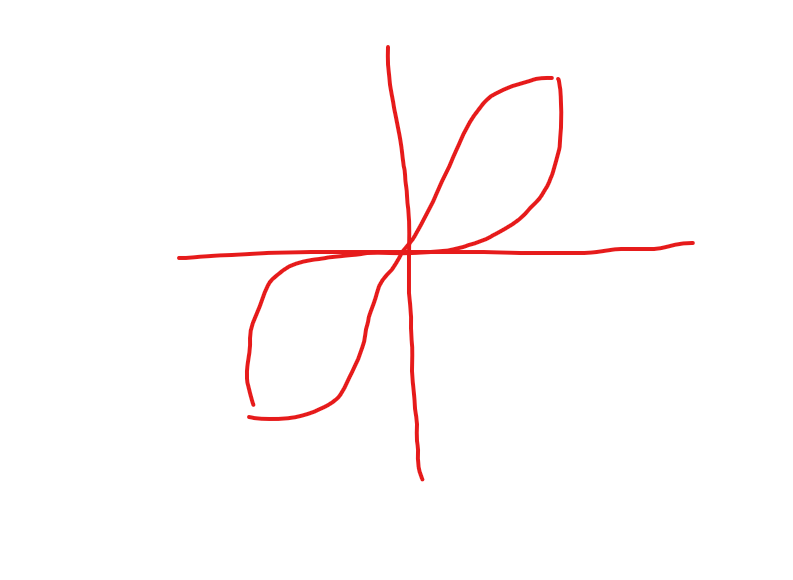

In [4]:
class Trader1:
    def __init__(self):
        self.position_limit = {"KELP": 50, "RAINFOREST_RESIN": 50}
        pass

    def take_best_orders(self, state: TradingState, orderbook: OrderDepth) -> list[Order]:
        orders: list[Order] = []

        symbol = "RAINFOREST_RESIN"
        position = state.position[symbol] if symbol in state.position else 0

        max_buy_amount = self.position_limit[symbol] - position
        max_sell_amount = abs(-self.position_limit[symbol] - position)

        if len(orderbook.buy_orders) != 0:
            best_bid_price = max(orderbook.buy_orders.keys())
            best_bid_volume = orderbook.buy_orders[best_bid_price]

            if best_bid_price > 10000:
                fill_quantity = min(max_sell_amount, best_bid_volume)

                if fill_quantity > 0:
                    orders.append(Order(symbol, best_bid_price, -fill_quantity))
                    del orderbook.buy_orders[best_bid_price]

        if len(orderbook.sell_orders) != 0:
            best_ask_price = min(orderbook.sell_orders.keys())
            best_ask_volume = abs(orderbook.sell_orders[best_ask_price])

            if best_ask_price < 10000:
                fill_quantity = min(max_buy_amount, best_ask_volume)

                if fill_quantity > 0:
                    orders.append(Order(symbol, best_ask_price, fill_quantity))
                    del orderbook.sell_orders[best_ask_price]

        return orders

    def run(self, state: TradingState):
        result = {}
        for product in state.order_depths:
            orders: list[Order] = []

            if product == "RAINFOREST_RESIN":
                took = self.take_best_orders(state, state.order_depths[product])

                while len(took) != 0:
                    orders = orders + took
                    took = self.take_best_orders(state, state.order_depths[product])

            result[product] = orders
        traderData = "SAMPLE"  # String value holding Trader state data required. It will be delivered as TradingState.traderData on next execution.

        conversions = 1
        return result, conversions, traderData


Lets do DP to find the max theoretical value we can gain.  
At time t, this DP knows the order book, and also the trades that will be executed by bots after we submit our trades for time t.   

The flow of processing for a round t is:
1. We get traderstate, can see existing orders.
2. We submit our orders
3. Bots submit more orders that can match our quotes.
4. t->t+1


Normally the algo doesn't have access to the info in (3.)  
But here we do. (to test theoretical max profit)

In [7]:
# state: dp[timestamp][position]
# represents the max pnl you can have with a position of pos.

from collections import defaultdict


market_data_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_0.csv"), sep=";")
trades_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_0.csv"), sep=";")

product = "KELP"

market_data_day_0 = market_data_day_0[market_data_day_0["product"] == product]
market_data_day_0 = market_data_day_0.set_index("timestamp")


trades_day_0 = trades_day_0[trades_day_0["symbol"] == product]

trade_history_by_timestamp = defaultdict(list)

for timestamp, group in trades_day_0.groupby("timestamp"):
    trade_history_by_timestamp[timestamp] = group.to_dict("records")


orderbook_asks = {}  # timestamp to asks dict
orderbook_bids = {}  # timestamp to bids dict


# this is how many timestamps we run it on (max 10000)
time_length = 10000 

for t in range(time_length):
    restingbids = defaultdict(int)
    restingasks = defaultdict(int)

    market_data_t = market_data_day_0.iloc[t]
    trade_history_t = trade_history_by_timestamp[t * 100]

    for i in range(1, 4, 1):
        if not pd.isna(market_data_t[f"bid_price_{i}"]):
            bidprice = market_data_t[f"bid_price_{i}"]
            bidvolume = market_data_t[f"bid_volume_{i}"]

            restingbids[bidprice] += bidvolume

    for i in range(1, 4, 1):
        if not pd.isna(market_data_t[f"ask_price_{i}"]):
            askprice = market_data_t[f"ask_price_{i}"]
            askvolume = market_data_t[f"ask_volume_{i}"]

            restingasks[askprice] += askvolume

    tradebids = defaultdict(int)
    tradeasks = defaultdict(int)

    for trade in trade_history_t:
        tradeprice = trade["price"]
        tradevolume = trade["quantity"]

        # determine if the newly placed trade was a buyer or a seller
        if restingbids[tradeprice] > 0:
            tradeasks[tradeprice] += tradevolume
        elif restingasks[tradeprice] > 0:
            tradebids[tradeprice] += tradevolume

    bids = defaultdict(int)
    asks = defaultdict(int)

    for d in [restingbids, tradebids]:
        for k, v in d.items():
            bids[k] += v

    for d in [restingasks, tradeasks]:
        for k, v in d.items():
            asks[k] += v

    orderbook_asks[t] = asks
    orderbook_bids[t] = bids


NEG_INF = -99999999
# # let cash[t,p] be the max amount of cash we can have after timestamp t, with a position of p
cash = {}  
best_trades = {} #map of [t,p] -> list of optimal trades to do 
prev = {} 

for i in range(-50, 51, 1):
    cash[-1, i] = NEG_INF
    best_trades[-1, i] = []

cash[-1, 0] = 0
best_trades[-1, 0] = []

for t in tqdm(range(time_length)):
    for p in range(-50, 51, 1):
        cash[t, p] = NEG_INF
        best_trades[t, p] = []

        for prevp in range(-50, 51, 1):
            if cash[t - 1, prevp] == NEG_INF:
                continue

            if p == prevp:
                if cash[t - 1, p] > cash[t, p]:
                    cash[t, p] = cash[t - 1, p]
                    best_trades[t, p] = []
                    prev[t, p] = (t - 1, p)

            elif p > prevp:
                # need to buy
                cashcost = 0
                reqbuy = p - prevp
                trades_executed = []

                sorted_asks = sorted(orderbook_asks[t].items())  # buy cheapest first
                for price, vol in sorted_asks:
                    if reqbuy == 0:
                        break

                    executed_vol = min(vol, reqbuy)
                    cashcost += executed_vol * price
                    reqbuy -= executed_vol

                    trades_executed.append(Trade(product, price, executed_vol, "SUBMISSION", "", t * 100))

                # Only update if we could buy enough
                if reqbuy == 0:
                    if cash[t - 1, prevp] - cashcost > cash[t, p]:
                        cash[t, p] = cash[t - 1, prevp] - cashcost
                        best_trades[t, p] = trades_executed
                        prev[t, p] = (t - 1, prevp)
                        

            elif p < prevp:
                # need to sell
                cashgain = 0
                reqsell = prevp - p
                trades_executed = []

                sorted_bids = sorted(orderbook_bids[t].items(), reverse=True)  # sell to most expensive first
                for price, vol in sorted_bids:
                    if reqsell == 0:
                        break

                    executed_vol = min(vol, reqsell)
                    cashgain += executed_vol * price
                    reqsell -= executed_vol

                    trades_executed.append(Trade(product, price, executed_vol, "", "SUBMISSION", t * 100))

                # Only update if we could sell enough
                if reqsell == 0:
                    if cash[t - 1, prevp] + cashgain > cash[t, p]:
                        cash[t, p] = cash[t - 1, prevp] + cashgain
                        best_trades[t, p] = trades_executed
                        prev[t, p] = (t - 1, prevp)


# best_profit = 0

# for pos in range(-50, 51, 1):
#     net = cash[time_length - 1, pos] + 10000 * pos
#     best_profit = max(best_profit, net)

    # print(f"Profit at {time_length-1}, {pos} is {net}")
print(f"Best profit at end of {time_length} = {cash[time_length-1, 0]}")

100%|██████████| 10000/10000 [02:51<00:00, 58.31it/s]

Best profit at end of 10000 = 12953.0


Now that we have the max profit, lets trace backwards to figure out what the best trades at each time are. Lets also visualise these

In [79]:
best_pos = 0
best_profit = 0

for pos in range(-50, 51, 1):
    net = cash[time_length - 1, pos] + 10000 * pos
    if net > best_profit:
        best_pos = pos
        best_profit = net


best_action: dict[int, list[Trade]] = {}  # map of timestamp -> list of trades to be done


t, p = time_length - 1, best_pos

while t != -1:
    best_action[t] = best_trades[t, p]
    t, p = prev[t, p]

best_action

{499: [],
 498: [(RAINFOREST_RESIN, SUBMISSION << , 9998, 1, 49800)],
 497: [(RAINFOREST_RESIN,  << SUBMISSION, 10002.0, 1, 49700)],
 496: [],
 495: [],
 494: [],
 493: [],
 492: [],
 491: [(RAINFOREST_RESIN, SUBMISSION << , 9998.0, 2, 49100)],
 490: [],
 489: [],
 488: [],
 487: [(RAINFOREST_RESIN,  << SUBMISSION, 10002, 2, 48700)],
 486: [],
 485: [],
 484: [],
 483: [],
 482: [],
 481: [],
 480: [],
 479: [],
 478: [(RAINFOREST_RESIN, SUBMISSION << , 9998, 1, 47800)],
 477: [(RAINFOREST_RESIN, SUBMISSION << , 9998, 1, 47700)],
 476: [(RAINFOREST_RESIN, SUBMISSION << , 9995.0, 2, 47600)],
 475: [],
 474: [],
 473: [],
 472: [],
 471: [],
 470: [(RAINFOREST_RESIN, SUBMISSION << , 9995.0, 2, 47000)],
 469: [],
 468: [(RAINFOREST_RESIN, SUBMISSION << , 9998.0, 1, 46800)],
 467: [],
 466: [],
 465: [],
 464: [],
 463: [],
 462: [],
 461: [],
 460: [(RAINFOREST_RESIN, SUBMISSION << , 9996.0, 3, 46000),
  (RAINFOREST_RESIN, SUBMISSION << , 9998, 5, 46000)],
 459: [],
 458: [],
 457: [(RAIN

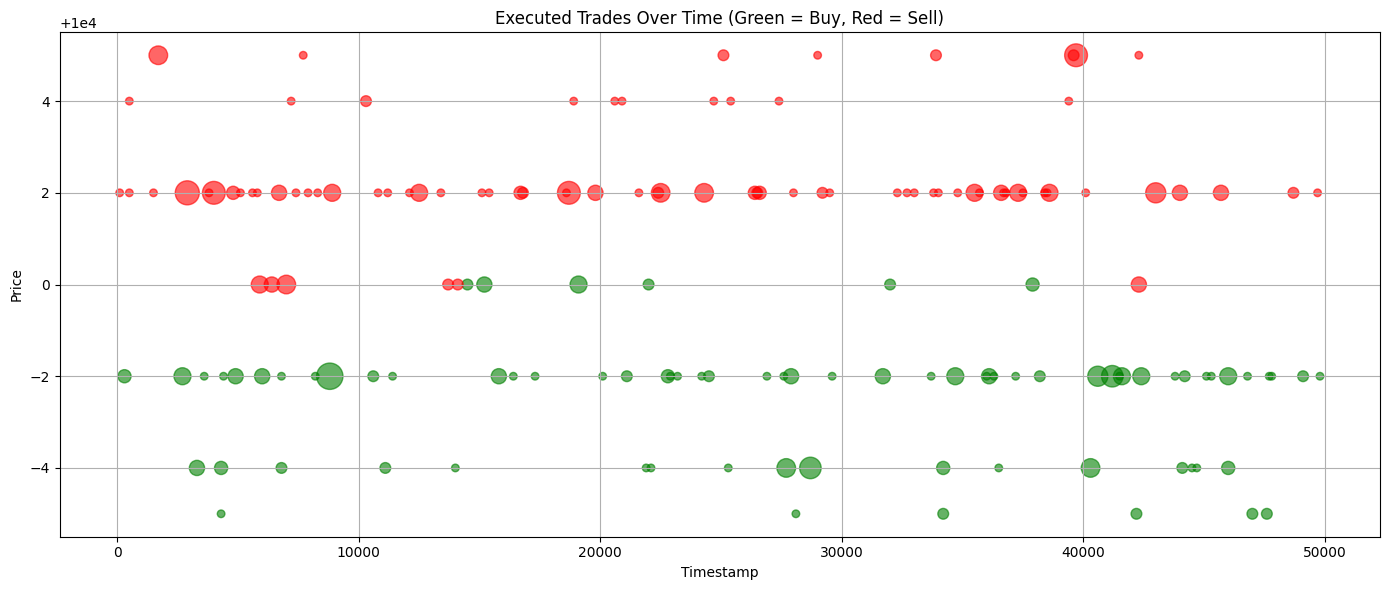

In [83]:
import matplotlib.pyplot as plt

# Collect all trades from the trades dictionary
timestamps = []
prices = []
sizes = []
colors = []

for t, trade_list in best_action.items():
    for trade in trade_list:
        # trade = Trade(product, price, volume, buyer, seller, timestamp)
        price = trade.price
        volume = trade.quantity
        timestamp = trade.timestamp

        # Skip invalid trades (just in case)
        if price is None or volume is None or timestamp is None:
            continue

        timestamps.append(timestamp)
        prices.append(price)
        sizes.append(volume * 30)  # scale dot size for visibility
        if trade.buyer == "SUBMISSION":
            colors.append("green")  # Buy
        elif trade.seller == "SUBMISSION":
            colors.append("red")    # Sell
        else:
            colors.append("gray")   # Unknown (fallback)

# Plotting
plt.figure(figsize=(14, 6))
plt.scatter(timestamps, prices, s=sizes, c=colors, alpha=0.6)
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("Executed Trades Over Time (Green = Buy, Red = Sell)")
plt.grid(True)
plt.tight_layout()
plt.show()


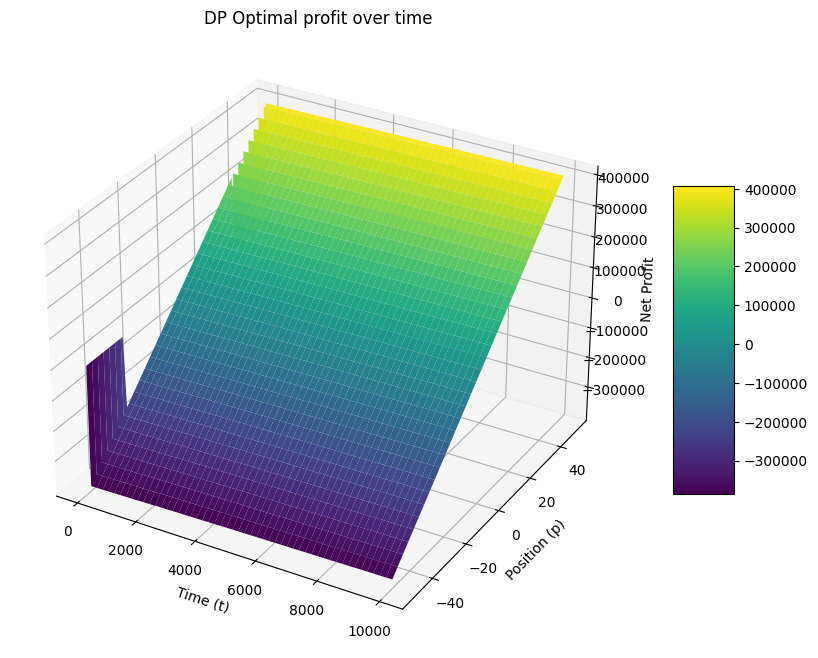

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Compute net profit: cash + 10000 * position.
# Note: Assuming NEG_INF is defined (e.g., NEG_INF = -99999999)
net = {}
for tp, c in cash.items():
    t, p = tp
    net[(t, p)] = c + 10000 * p

# Define time and position ranges.
time_range = np.arange(time_length)  # t = 0, 1, ..., time_length-1
positions = np.arange(-50, 51)  # p = -50, -49, ..., 50

# Create a mesh grid from the time and position ranges.
T, P = np.meshgrid(time_range, positions)

# Build the corresponding Z matrix (net profit) from your net dictionary.
# Replace NEG_INF values with np.nan so they aren't plotted.
Z = np.empty_like(T, dtype=float)
for i, p in enumerate(positions):
    for j, t in enumerate(time_range):
        Z[i, j] = 0 if cash[t, p] == NEG_INF else net[t, p]

# Now, create the 3D surface plot.
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the surface.
surf = ax.plot_surface(T, P, Z, cmap="viridis", edgecolor="none", antialiased=True)
ax.set_xlabel("Time (t)")
ax.set_ylabel("Position (p)")
ax.set_zlabel("Net Profit")
ax.set_title("DP Optimal profit over time")


# Add a color bar.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Ok lets try make an algo now. It seems that the optimal solution just involves taking quite small trades... Therefore we shouldn't have to worry too much about managing position size and determining if we should forgo +ev trades for MORE +ev trades in the future.   

I think something as simple as just 
1. Taking all +ev trades from orderbook
2. quoting a little bit on both sides
Should work reasonably well?

We can take no_mm_test.py from before and just add some stuff...  

Leafing seems a bit too overkill for now, and isn't the point of leafing (as in the leaf aspect - not the dynamic sizing aspect) to reduce the amount of back-and-forth resulting from price fluctuations? But like here theo price is constant 10000.?  




In [3]:
class ResinTrader1:
    def __init__(self):
        # config
        self.position_limit = {"RAINFOREST_RESIN": 50}
        self.symbol = "RAINFOREST_RESIN"

        self.sk1 = 0.00
        self.sk2 = 0.00
        self.sk3 = 0.00
        self.sk4 = 0.00
        self.sk5 = 0.00
        self.bk1 = 0.00
        self.bk2 = 0.00
        self.bk3 = 0.00
        self.bk4 = 0.00
        self.bk5 = 0.00

        # runtime
        self.max_position = 0
        self.min_position = 0
        pass

    # takes +ev orders from the orderbook.
    def take_best_orders(self, state: TradingState, orderbook: OrderDepth) -> list[Order]:
        orders: list[Order] = []

        max_buy_amount = self.position_limit[self.symbol] - self.max_position
        max_sell_amount = abs(-self.position_limit[self.symbol] - self.min_position)

        if len(orderbook.buy_orders) != 0:
            best_bid_price = max(orderbook.buy_orders.keys())
            best_bid_volume = orderbook.buy_orders[best_bid_price]

            if best_bid_price > 10000:
                fill_quantity = min(max_sell_amount, best_bid_volume)

                if fill_quantity > 0:
                    orders.append(Order(self.symbol, best_bid_price, -fill_quantity))
                    del orderbook.buy_orders[best_bid_price]

        if len(orderbook.sell_orders) != 0:
            best_ask_price = min(orderbook.sell_orders.keys())
            best_ask_volume = abs(orderbook.sell_orders[best_ask_price])

            if best_ask_price < 10000:
                fill_quantity = min(max_buy_amount, best_ask_volume)

                if fill_quantity > 0:
                    orders.append(Order(self.symbol, best_ask_price, fill_quantity))
                    del orderbook.sell_orders[best_ask_price]

        return orders

    # puts in some quoting orders
    def add_mm_orders(self, state: TradingState) -> list[Order]:
        orders: list[Order] = []

        max_buy_amount = self.position_limit[self.symbol] - self.max_position
        max_sell_amount = abs(-self.position_limit[self.symbol] - self.min_position)

       
        portion = max_sell_amount / 5
        sq1 = self.sk1 * portion
        sq2 = self.sk2 * portion
        sq3 = self.sk3 * portion
        sq4 = self.sk4 * portion
        sq5 = self.sk5 * (max_sell_amount - 4 * int(portion))

        portion = max_buy_amount / 5
        bq1 = self.bk1 * portion
        bq2 = self.bk2 * portion
        bq3 = self.bk3 * portion
        bq4 = self.bk4 * portion
        bq5 = self.bk5 * (max_buy_amount - 4 * int(portion))

        orders.append(Order(self.symbol, 10001, -int(sq1)))
        orders.append(Order(self.symbol, 10002, -int(sq2)))
        orders.append(Order(self.symbol, 10003, -int(sq3)))
        orders.append(Order(self.symbol, 10004, -int(sq4)))
        orders.append(Order(self.symbol, 10005, -int(sq5)))

        orders.append(Order(self.symbol, 9999, int(bq1)))
        orders.append(Order(self.symbol, 9998, int(bq2)))
        orders.append(Order(self.symbol, 9997, int(bq3)))
        orders.append(Order(self.symbol, 9996, int(bq4)))
        orders.append(Order(self.symbol, 9995, int(bq5)))

        return orders

    def init_runtime_variables(self, state: TradingState):
        self.max_position = state.position[self.symbol] if self.symbol in state.position else 0
        self.min_position = state.position[self.symbol] if self.symbol in state.position else 0

    def run(self, state: TradingState):
        self.init_runtime_variables(state)

        result = {}
        for product in state.order_depths:
            orders: list[Order] = []

            if product == "RAINFOREST_RESIN":
                took = self.take_best_orders(state, state.order_depths[product])

                while len(took) != 0:
                    orders = orders + took

                    for order in took:
                        if order.quantity > 0:
                            self.max_position += order.quantity
                        elif order.quantity < 0:
                            self.min_position -= abs(order.quantity)

                    took = self.take_best_orders(state, state.order_depths[product])

                took = self.add_mm_orders(state)
                orders = orders + took

                for order in took:
                    if order.quantity > 0:
                        self.max_position += order.quantity
                    elif order.quantity < 0:
                        self.min_position -= abs(order.quantity)

            result[product] = orders
        traderData = "SAMPLE"  # String value holding Trader state data required. It will be delivered as TradingState.traderData on next execution.

        conversions = 1
        return result, conversions, traderData

In [11]:
# 1. Define the listings.
listings = {
    "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
}

# 2. Define the position limits.
position_limit = {
    "KELP": 50,
    "RAINFOREST_RESIN": 50,
    "SQUID_INK": 50,
}


# 3. Define fair value evaluation functions. This is used to determine what our PNL is at times throughout execution when our net position is not 0.
def calc_rainforest_resin_fair(order_depth: OrderDepth) -> float:
    return 10000


fair_value_evaluator = {
    # omitting dictionary entries for KELP, SQUID_INK, so that they use default behaviour: fair_price = (best_bid+best_ask)/2
    "RAINFOREST_RESIN": calc_rainforest_resin_fair,
}


# 4. Market data and trade history files.
market_data_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_0.csv"), sep=";")
market_data_day_neg1 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-1.csv"), sep=";")
market_data_day_neg2 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-2.csv"), sep=";")

trades_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_0.csv"), sep=";")
trades_day_neg1 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_-1.csv"), sep=";")
trades_day_neg2 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_-2.csv"), sep=";")


# 5. Instantiate trader object
# Define the function to be run in each process

from joblib import Parallel, delayed
from itertools import product
from tqdm import tqdm


# Function to be parallelized
def run_backtest_independent(sk3, sk4, bk3, bk4):
    trader = ResinTrader1()

    # Set sk values
    trader.sk1 = 0.0
    trader.sk2 = 0.0
    trader.sk3 = sk3
    trader.sk4 = sk4
    trader.sk5 = 0.0

    # Set bk values
    trader.bk1 = 0.0
    trader.bk2 = 0.0
    trader.bk3 = bk3
    trader.bk4 = bk4
    trader.bk5 = 0.0

    # Run backtester
    bt = Backtester(
        trader,
        listings,
        position_limit,
        fair_value_evaluator,
        market_data_day_neg2,
        trades_day_neg2,
        output_log_filename=None
    )
    bt.run()

    pnl = bt.pnl["RAINFOREST_RESIN"]
    return ((sk3, sk4, bk3, bk4), pnl)

# Grid resolutions
n_sk3 = 7  # points in [0.7, 1.0]
n_sk4 = 7  # points in [0.0, 0.3]
n_bk3 = 7
n_bk4 = 7

# Value ranges
sk3_vals = np.linspace(0.7, 1.0, n_sk3)
sk4_vals = np.linspace(0.0, 0.3, n_sk4)
bk3_vals = np.linspace(0.7, 1.0, n_bk3)
bk4_vals = np.linspace(0.0, 0.3, n_bk4)

# Create valid parameter grid with sum constraints
param_grid = [
    (sk3, sk4, bk3, bk4)
    for sk3, sk4, bk3, bk4 in product(sk3_vals, sk4_vals, bk3_vals, bk4_vals)
    if (sk3 + sk4 <= 1.0) and (bk3 + bk4 <= 1.0)
]

# print(f"Running {len(param_grid)} combinations with varying sk3/sk4 and bk3/bk4...")

# Run in parallel with progress bar
results = Parallel(n_jobs=-1)(
    delayed(run_backtest_independent)(*params)
    for params in tqdm(param_grid, desc="Grid Search")
)

# Sort results
scores = dict(results)
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

# Print top results
print("\nTop results:")
for params, pnl in sorted_scores[:20]:
    print(f"sk3={params[0]:.2f}, sk4={params[1]:.2f}, bk3={params[2]:.2f}, bk4={params[3]:.2f} => P&L={pnl:.2f}")






































































































Grid Search: 100%|██████████| 784/784 [05:30<00:00,  2.37it/s]



Top results:
sk3=1.00, sk4=0.00, bk3=0.70, bk4=0.30 => P&L=15076.00
sk3=0.95, sk4=0.00, bk3=0.70, bk4=0.30 => P&L=15044.00
sk3=0.95, sk4=0.05, bk3=0.70, bk4=0.30 => P&L=15044.00
sk3=1.00, sk4=0.00, bk3=0.75, bk4=0.25 => P&L=15020.00
sk3=0.90, sk4=0.00, bk3=0.70, bk4=0.30 => P&L=14988.00
sk3=0.90, sk4=0.05, bk3=0.70, bk4=0.30 => P&L=14988.00
sk3=0.90, sk4=0.10, bk3=0.70, bk4=0.30 => P&L=14988.00
sk3=0.95, sk4=0.00, bk3=0.75, bk4=0.25 => P&L=14981.00
sk3=0.95, sk4=0.05, bk3=0.75, bk4=0.25 => P&L=14981.00
sk3=1.00, sk4=0.00, bk3=0.70, bk4=0.25 => P&L=14973.00
sk3=0.90, sk4=0.00, bk3=0.75, bk4=0.25 => P&L=14966.00
sk3=0.90, sk4=0.05, bk3=0.75, bk4=0.25 => P&L=14966.00
sk3=0.90, sk4=0.10, bk3=0.75, bk4=0.25 => P&L=14966.00
sk3=0.85, sk4=0.15, bk3=0.75, bk4=0.25 => P&L=14947.00
sk3=0.85, sk4=0.00, bk3=0.75, bk4=0.25 => P&L=14939.00
sk3=0.85, sk4=0.05, bk3=0.75, bk4=0.25 => P&L=14939.00
sk3=0.85, sk4=0.10, bk3=0.75, bk4=0.25 => P&L=14939.00
sk3=0.85, sk4=0.15, bk3=0.70, bk4=0.30 => P&L=14938

running on day -1 we get this

params=(0.0, 0.0, 0.875, 0.125, 0.0), P&L=14203.00 
params=(0.0, 0.0, 1.0, 0.0, 0.0), P&L=14151.00
params=(0.0, 0.0, 0.75, 0.25, 0.0), P&L=14125.00
params=(0.0, 0.0, 0.875, 0.0, 0.0), P&L=14006.00
params=(0.0, 0.0, 0.875, 0.0, 0.125), P&L=14006.00
params=(0.0, 0.0, 0.75, 0.125, 0.0), P&L=13950.00
params=(0.0, 0.0, 0.75, 0.125, 0.125), P&L=13950.00
params=(0.0, 0.0, 0.625, 0.375, 0.0), P&L=13813.00
params=(0.0, 0.0, 0.75, 0.0, 0.0), P&L=13776.00
params=(0.0, 0.0, 0.75, 0.0, 0.125), P&L=13776.00
params=(0.0, 0.0, 0.75, 0.0, 0.25), P&L=13776.00
params=(0.0, 0.0, 0.625, 0.25, 0.0), P&L=13751.00
params=(0.0, 0.0, 0.625, 0.25, 0.125), P&L=13751.00
params=(0.0, 0.0, 0.625, 0.125, 0.0), P&L=13562.00
params=(0.0, 0.0, 0.625, 0.125, 0.125), P&L=13562.00
params=(0.0, 0.0, 0.625, 0.125, 0.25), P&L=13562.00
params=(0.0, 0.0, 0.625, 0.0, 0.0), P&L=13385.00
params=(0.0, 0.0, 0.625, 0.0, 0.125), P&L=13385.00
params=(0.0, 0.0, 0.625, 0.0, 0.25), P&L=13385.00
params=(0.0, 0.0, 0.625, 0.0, 0.375), P&L=13385.00


Top results:
sk3=1.00, sk4=0.00, bk3=0.75, bk4=0.25 => P&L=14394.00
sk3=1.00, sk4=0.00, bk3=0.80, bk4=0.20 => P&L=14372.00
sk3=1.00, sk4=0.00, bk3=0.70, bk4=0.30 => P&L=14361.00
sk3=0.95, sk4=0.00, bk3=0.75, bk4=0.25 => P&L=14348.00
sk3=0.95, sk4=0.05, bk3=0.75, bk4=0.25 => P&L=14348.00
sk3=1.00, sk4=0.00, bk3=0.75, bk4=0.20 => P&L=14331.00
sk3=0.95, sk4=0.00, bk3=0.80, bk4=0.20 => P&L=14328.00
sk3=0.95, sk4=0.05, bk3=0.80, bk4=0.20 => P&L=14328.00
sk3=1.00, sk4=0.00, bk3=0.70, bk4=0.25 => P&L=14328.00
sk3=1.00, sk4=0.00, bk3=0.85, bk4=0.15 => P&L=14317.00
sk3=0.90, sk4=0.00, bk3=0.75, bk4=0.25 => P&L=14316.00
sk3=0.90, sk4=0.05, bk3=0.75, bk4=0.25 => P&L=14316.00
sk3=0.90, sk4=0.10, bk3=0.75, bk4=0.25 => P&L=14316.00
sk3=0.95, sk4=0.00, bk3=0.70, bk4=0.30 => P&L=14315.00
sk3=0.95, sk4=0.05, bk3=0.70, bk4=0.30 => P&L=14315.00
sk3=0.95, sk4=0.00, bk3=0.70, bk4=0.25 => P&L=14292.00
sk3=0.95, sk4=0.05, bk3=0.70, bk4=0.25 => P&L=14292.00
sk3=0.90, sk4=0.00, bk3=0.80, bk4=0.20 => P&L=14291.00
sk3=0.90, sk4=0.05, bk3=0.80, bk4=0.20 => P&L=14291.00
sk3=0.90, sk4=0.10, bk3=0.80, bk4=0.20 => P&L=14291.00


I think this was running on day 0 or something
# [((0.7, 0.2, 0.0, 0.6, 0.38, 0.0), 12674),
#  ((0.7, 0.26, 0.0, 0.6, 0.38, 0.0), 12674),
#  ((0.6499999999999999, 0.2, 0.0, 0.6, 0.38, 0.0), 12660),
#  ((0.6499999999999999, 0.26, 0.0, 0.6, 0.38, 0.0), 12660),
#  ((0.6499999999999999, 0.32, 0.0, 0.6, 0.38, 0.0), 12660),
#  ((0.6, 0.2, 0.0, 0.6, 0.38, 0.0), 12644),
#  ((0.6, 0.26, 0.0, 0.6, 0.38, 0.0), 12644),
#  ((0.6, 0.32, 0.0, 0.6, 0.38, 0.0), 12644),
#  ((0.6, 0.38, 0.0, 0.6, 0.38, 0.0), 12644),
#  ((0.7, 0.2, 0.0, 0.55, 0.44, 0.0), 12642),
#  ((0.7, 0.2, 0.0, 0.6499999999999999, 0.32, 0.0), 12642),
#  ((0.7, 0.26, 0.0, 0.55, 0.44, 0.0), 12642),
#  ((0.7, 0.26, 0.0, 0.6499999999999999, 0.32, 0.0), 12642),
#  ((0.7, 0.2, 0.0, 0.5, 0.44, 0.0), 12638),
#  ((0.7, 0.2, 0.0, 0.6, 0.32, 0.0), 12638),
#  ((0.7, 0.26, 0.0, 0.5, 0.44, 0.0), 12638),
#  ((0.7, 0.26, 0.0, 0.6, 0.32, 0.0), 12638),
#  ((0.7, 0.2, 0.0, 0.5, 0.5, 0.0), 12636),
#  ((0.7, 0.26, 0.0, 0.5, 0.5, 0.0), 12636),
#  ((0.6499999999999999, 0.2, 0.0, 0.6499999999999999, 0.32, 0.0), 12630),
#  ((0.6499999999999999, 0.26, 0.0, 0.6499999999999999, 0.32, 0.0), 12630),
#  ((0.6499999999999999, 0.32, 0.0, 0.6499999999999999, 0.32, 0.0), 12630),
#  ((0.7, 0.2, 0.0, 0.55, 0.38, 0.0), 12628),
#  ((0.7, 0.26, 0.0, 0.55, 0.38, 0.0), 12628),
#  ((0.6499999999999999, 0.2, 0.0, 0.6, 0.32, 0.0), 12624),


on imc website, the below gets 1562shells 
        self.sk2 = 0.70
        self.sk4 = 0.26
        self.sk5 = 0.00
        self.bk2 = 0.60
        self.bk4 = 0.38
        self.bk5 = 0.00

on imc website, the below gets 1816
        self.sk1 = 0.00
        self.sk2 = 0.00
        self.sk3 = 0.875
        self.sk4 = 0.125
        self.sk5 = 0.00
        self.bk1 = 0.00
        self.bk2 = 0.00
        self.bk3 = 0.875
        self.bk4 = 0.125
        self.bk5 = 0.00

on imc website, the below gets 1819
        self.sk1 = 0.00
        self.sk2 = 0.00
        self.sk3 = 1.0
        self.sk4 = 0.0
        self.sk5 = 0.00
        self.bk1 = 0.00
        self.bk2 = 0.00
        self.bk3 = 0.75
        self.bk4 = 0.25
        self.bk5 = 0.00

This works reasonably well, getting us decently close to the theo max of 19500.  

However, something I observe is that for the quoting - when I quote e.g. 9996 and 9995 order, the bots will take that 9996 order. I miss out on a dollar. You can see this in the filled_trades graph. The trades that are getting filled by me, are just the trades that were getting filled by bots instead, but shifted up by 1 (im losing a dollar of EV).  

So basically I think the bots are informed - since im just quoting 1/3 1/3 1/3 at +-2, +-4, +-5, this allows them to buy cheaper.  

seems like the +-5 quotes never get filled? its probably because time price priority or something...  
Seems like by gridsearching the optimal strat is to not quote any at +-5.  

Its like k2 = 0.6, k4 = 0.3   
or k2 = 0.7, k4 = 0.2  
or k2 = 0.5, k4 = 0.4

Lets look at how many quotes are placed by the bots over time at various intervals.  

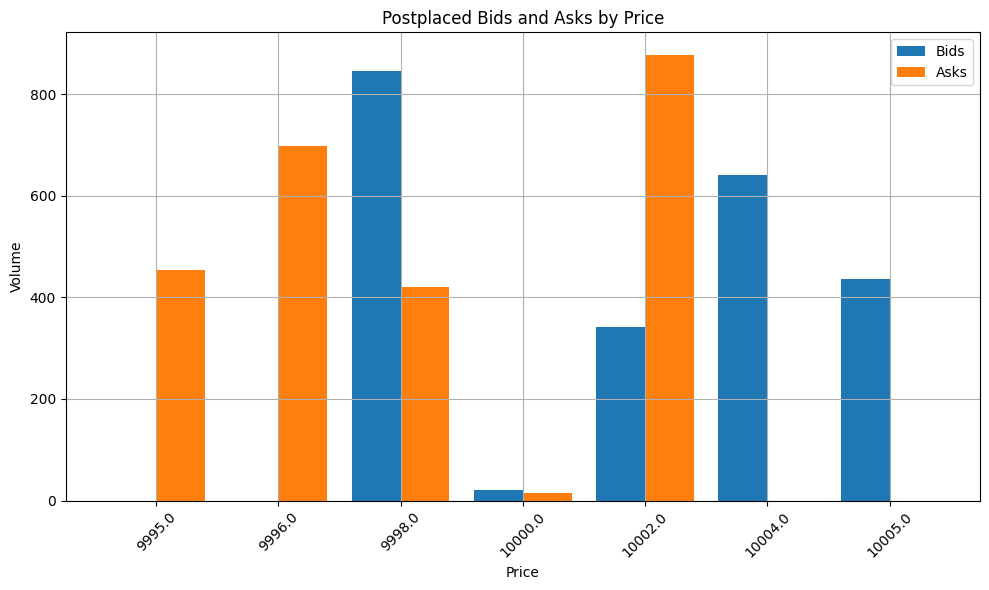

In [ ]:
market_data_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_0.csv"), sep=";")
trades_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_0.csv"), sep=";")


market_data_day_0 = market_data_day_0[market_data_day_0["product"] == "RAINFOREST_RESIN"]
market_data_day_0 = market_data_day_0.set_index("timestamp")


trades_day_0 = trades_day_0[trades_day_0["symbol"] == "RAINFOREST_RESIN"]

trade_history_by_timestamp = defaultdict(list)

for timestamp, group in trades_day_0.groupby("timestamp"):
    trade_history_by_timestamp[timestamp] = group.to_dict("records")


# placed after .run()
postplaced_asks = defaultdict(int)
postplaced_bids = defaultdict(int)


# this is how many timestamps we run it on (max 10000)
time_length = 10000

for t in range(time_length):
    restingbids = defaultdict(int)
    restingasks = defaultdict(int)

    market_data_t = market_data_day_0.iloc[t]
    trade_history_t = trade_history_by_timestamp[t * 100]

    for i in range(1, 4, 1):
        if not pd.isna(market_data_t[f"bid_price_{i}"]):
            bidprice = market_data_t[f"bid_price_{i}"]
            bidvolume = market_data_t[f"bid_volume_{i}"]

            restingbids[bidprice] += bidvolume

    for i in range(1, 4, 1):
        if not pd.isna(market_data_t[f"ask_price_{i}"]):
            askprice = market_data_t[f"ask_price_{i}"]
            askvolume = market_data_t[f"ask_volume_{i}"]

            restingasks[askprice] += askvolume

    tradebids = defaultdict(int)
    tradeasks = defaultdict(int)

    for trade in trade_history_t:
        tradeprice = trade["price"]
        tradevolume = trade["quantity"]

        # determine if the newly placed trade was a buyer or a seller
        if restingbids[tradeprice] > 0:
            tradeasks[tradeprice] += tradevolume
        elif restingasks[tradeprice] > 0:
            tradebids[tradeprice] += tradevolume

    bids = defaultdict(int)
    asks = defaultdict(int)

    for k, v in tradebids.items():
        postplaced_bids[k] += v

    for k, v in tradeasks.items():
        postplaced_asks[k] += v


import matplotlib.pyplot as plt

# Plotting histogram
plt.figure(figsize=(10, 6))

# Sort keys for consistent x-axis
all_prices = sorted(set(postplaced_bids.keys()).union(set(postplaced_asks.keys())))

bid_volumes = [postplaced_bids[price] for price in all_prices]
ask_volumes = [postplaced_asks[price] for price in all_prices]

bar_width = 0.4
x = range(len(all_prices))

plt.bar([i - bar_width / 2 for i in x], bid_volumes, width=bar_width, label="Bids")
plt.bar([i + bar_width / 2 for i in x], ask_volumes, width=bar_width, label="Asks")

plt.xticks(x, all_prices, rotation=45)
plt.xlabel("Price")
plt.ylabel("Volume")
plt.title("Postplaced Bids and Asks by Price")
plt.legend()
plt.tight_layout()
plt.grid(True)

plt.show()

Over the course of 10000 time intervals, this is what we observe

so we should divide by 10000, to get the average bids per tick.  

this gives us about 0.043 of 9995, 0.07 of 9996, 0.043 of 9998  

does GTO come in to play here? become unexploitable?  

give 


In [ ]:
# 1. Define the listings.
listings = {
    "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
}

# 2. Define the position limits.
position_limit = {
    "KELP": 50,
    "RAINFOREST_RESIN": 50,
    "SQUID_INK": 50,
}


# 3. Define fair value evaluation functions. This is used to determine what our PNL is at times throughout execution when our net position is not 0.
def calc_rainforest_resin_fair(order_depth: OrderDepth) -> float:
    return 10000


fair_value_evaluator = {
    # omitting dictionary entries for KELP, SQUID_INK, so that they use default behaviour: fair_price = (best_bid+best_ask)/2
    "RAINFOREST_RESIN": calc_rainforest_resin_fair,
}


# 4. Market data and trade history files.
market_data_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_0.csv"), sep=";")
market_data_day_neg1 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-1.csv"), sep=";")
market_data_day_neg2 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-2.csv"), sep=";")

trades_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_0.csv"), sep=";")
trades_day_neg1 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_-1.csv"), sep=";")
trades_day_neg2 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_-2.csv"), sep=";")


trader = ResinTrader1()


trader.sk2 = 0.0
trader.sk4 = 0.0
trader.sk5 = 0.00


trader.bk2 = 0.0
trader.bk4 = 0.0
trader.bk5 = 0.00


bt = Backtester(
    trader, listings, position_limit, fair_value_evaluator, market_data_day_neg1, trades_day_neg1, output_log_filename="output.log"  
)
bt.run()

print(bt.pnl)

{'KELP': 0.0, 'RAINFOREST_RESIN': 18306, 'SQUID_INK': 0.0}
